# 2018 Data Science Bowl

In [1]:
%matplotlib inline

from PIL import Image
import pandas as pd
import os
import seaborn as sns
import numpy as np
import matplotlib.image as mpimg

In [2]:
import sys

sys.path.append('../../computer_vision_framework')
from bounding_box_utils  import calc_mask_bounding_box
from image_bounding_box_display_utils import show_image_and_bounding_box,add_rectangle,show_image_and_multiple_bounding_boxes

## Data exploration

In [3]:
train_images_paths = os.listdir('../../data/stage1_train')
print(len(train_images_paths))

670


In [4]:
if ('.DS_Store' in train_images_paths):
    train_images_paths.remove('.DS_Store')

In [5]:
train_img_masks = []
for train_img in train_images_paths:
    path = '../../data/stage1_train/'+train_img+'/masks/'
    train_images_masks = os.listdir(path)
    for mask in train_images_masks:
        train_img_masks.append((train_img,path+mask))
    
train_masks = pd.DataFrame.from_records(train_img_masks, columns=['ImageId', 'mask'])

In [6]:
train_labels = pd.read_csv('../../data/stage1_train_labels.csv')

In [7]:
train_labels.head(5)

,ImageId,EncodedPixels
0,00071198d059ba7f5914a526d124d28e6d010c92466da2...,6908 1 7161 8 7417 8 7672 9 7928 9 8184 9 8440...
1,00071198d059ba7f5914a526d124d28e6d010c92466da2...,36269 7 36523 11 36778 13 37033 15 37288 17 37...
2,00071198d059ba7f5914a526d124d28e6d010c92466da2...,19919 6 20174 8 20429 10 20685 11 20941 12 211...
3,00071198d059ba7f5914a526d124d28e6d010c92466da2...,18671 6 18926 8 19181 9 19436 10 19691 11 1994...
4,00071198d059ba7f5914a526d124d28e6d010c92466da2...,40158 3 40413 5 40669 5 40925 5 41182 3


### Mask distribution by Image

In [8]:
counts_imgageId = train_labels.groupby('ImageId', as_index=False).agg('count').rename(index=str, columns={"EncodedPixels": "count"})

In [9]:
counts_imgageId_masks = train_masks.groupby('ImageId', as_index=False).agg('count').rename(index=str, columns={"mask": "count_mask"})

In [10]:
counts_imgageId.describe()

,count
count,670.000000
mean,43.971642
std,47.962530
min,1.000000
25%,15.250000
50%,27.000000
75%,54.000000
max,375.000000


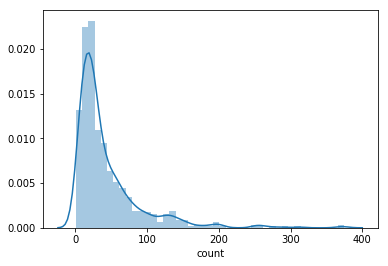

In [11]:
sns.distplot(counts_imgageId['count'])

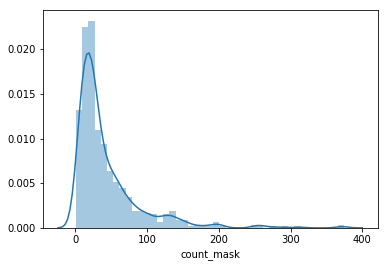

In [12]:
sns.distplot(counts_imgageId_masks['count_mask'])

In [13]:
validate_counts = pd.merge(counts_imgageId, counts_imgageId_masks, left_on='ImageId', right_on='ImageId', how='left')

In [14]:
validate_counts[validate_counts['count'] != validate_counts['count_mask']]

,ImageId,count,count_mask


### Images format

In [15]:
train_img_masks = []
extensions = []
extensions_masks = []

images_sizes = []
masks_sizes = []

image_shape = []

for train_img in train_images_paths:
    path = '../../data/stage1_train/'+train_img+'/images/'
    file = os.listdir(path)
    filename, file_extension = os.path.splitext(file[0])
    extensions.append(file_extension)
    ### get image_size
    img = Image.open(path + file[0])
    width, height = img.size
    images_sizes.append((width, height))
    ## Validate if the image is RGB
    img_array = np.array(img)
    if (len(img_array.shape) < 3 ):
        image_shape.append('Gray shape (w,h)')
    else:
        if(img_array.shape[2] == 3):
            image_shape.append('RGB (w,h,3)')
        if(img_array.shape[2] == 4):
            image_shape.append('ARGB shape (w,h,4)')
    ### Mask extensions and size ###
    path = '../../data/stage1_train/'+train_img+'/masks/'
    train_images_masks = os.listdir(path)
    if ('.DS_Store' in train_images_masks):
        train_images_masks.remove('.DS_Store')
    for mask in train_images_masks:
        filename, file_extension = os.path.splitext(mask)
        extensions_masks.append(file_extension)
        width, height = Image.open(path + mask).size
        masks_sizes.append((width, height))
    
print(set(extensions))
print(set(extensions_masks))

{'.png'}
{'.png'}


### Are the images RGB

In [16]:
print(set(image_shape))

{'ARGB shape (w,h,4)'}


## Are all the images the same size?

### Get height and weight and area of masks

In [17]:
print("Images sizes:")
print(set(images_sizes))

Images sizes:
{(696, 520), (320, 256), (1024, 1024), (256, 256), (640, 512), (1272, 603), (360, 360), (347, 260), (1388, 1040)}


In [17]:
print("Mask sizes:")
print(set(masks_sizes))

Mask sizes:
{(320, 256), (696, 520), (256, 256), (1024, 1024), (640, 512), (1272, 603), (360, 360), (347, 260), (1388, 1040)}


In [18]:
heights = np.array(images_sizes)[:,0]
widths = np.array(images_sizes)[:,1]

areas = heights  * widths

#### Get percentile, distribution of the height,weigth and area of images

##### Heights

In [19]:
pd.DataFrame(heights).describe()

,0
count,670.000000
mean,378.500000
std,204.838693
min,256.000000
25%,256.000000
50%,320.000000
75%,360.000000
max,1388.000000


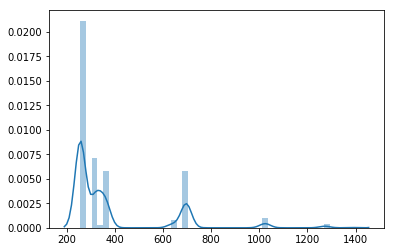

In [20]:
sns.distplot(heights)

##### Widths

In [21]:
pd.DataFrame(widths).describe()

,0
count,670.000000
mean,333.991045
std,149.474845
min,256.000000
25%,256.000000
50%,256.000000
75%,360.000000
max,1040.000000


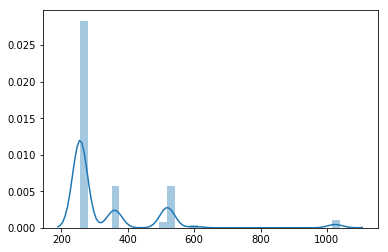

In [22]:
sns.distplot(widths)

##### Image areas

In [23]:
pd.DataFrame(areas).describe()

,0
count,6.700000e+02
mean,1.547583e+05
std,1.908250e+05
min,6.553600e+04
25%,6.553600e+04
50%,8.192000e+04
75%,1.296000e+05
max,1.443520e+06


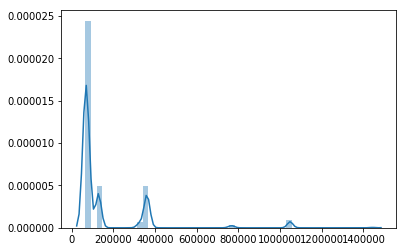

In [24]:
sns.distplot(areas)

## Test computer_vision_framework utils

In [25]:
test_mask_files = []

for train_img in train_images_paths[:1]:
    path = '../../data/stage1_train/'+train_img+'/masks/'
    print(path)
    train_images_masks = os.listdir(path)
    for mask in train_images_masks:
        test_mask_files.append(path + mask)

test_mask_files[:1]     

../../data/stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/masks/


['../../data/stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/masks/5522143fa8723b66b1e0b25331047e6ae6eeec664f7c8abeba687e0de0f9060a.png']

In [26]:
path = '../../data/stage1_train/'+str(train_images_paths[:1][0])+'/images/'+str(train_images_paths[:1][0])+".png"
image = mpimg.imread(path)

AREA:  99
AREA:  195
AREA:  399
AREA:  153
AREA:  483
AREA:  221
AREA:  315
AREA:  25
AREA:  621
AREA:  323
AREA:  99
AREA:  665
AREA:  441
AREA:  25
AREA:  399
AREA:  529
AREA:  391
AREA:  391
AREA:  575
AREA:  85
AREA:  247
AREA:  25
AREA:  171
AREA:  323
AREA:  25
AREA:  357
AREA:  315


/home/luis/anaconda2/envs/tf14_gpu_py3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


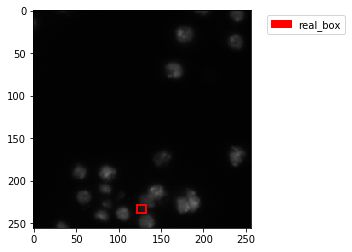

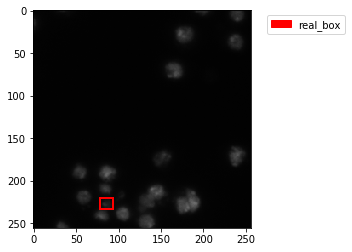

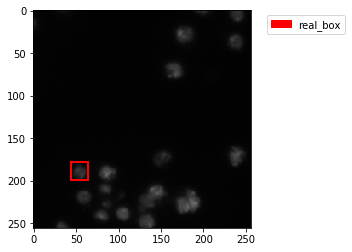

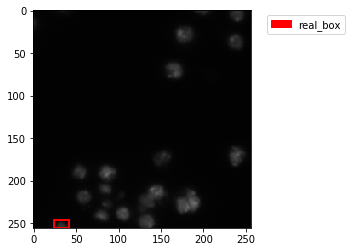

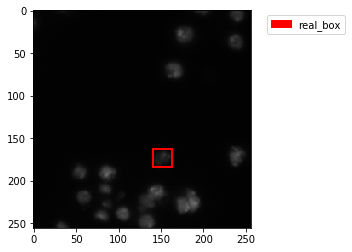

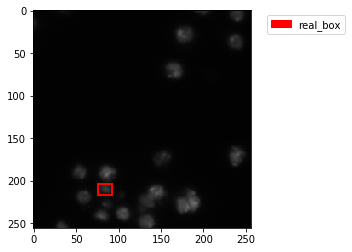

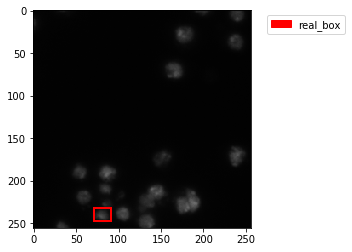

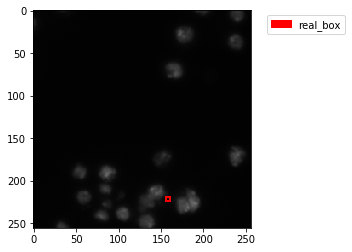

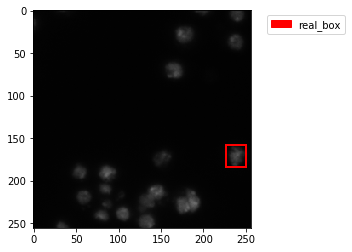

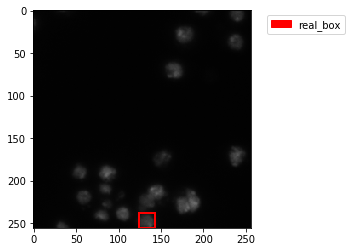

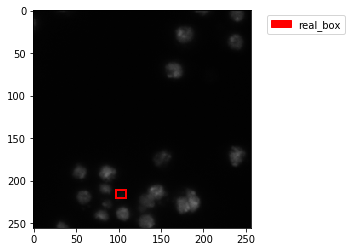

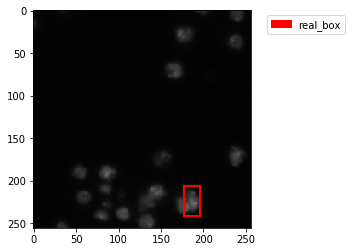

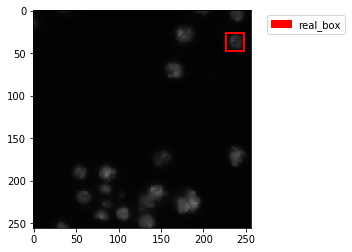

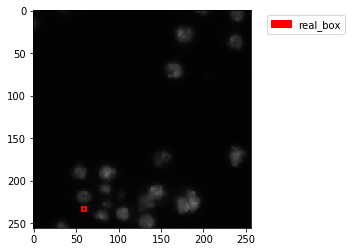

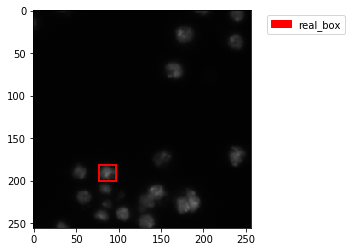

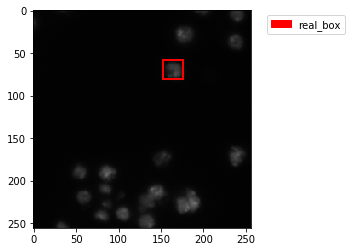

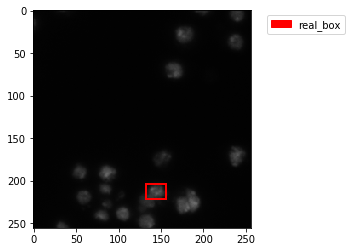

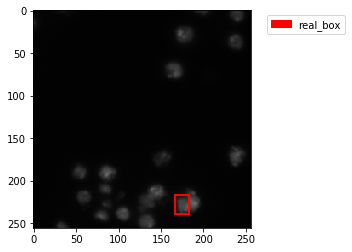

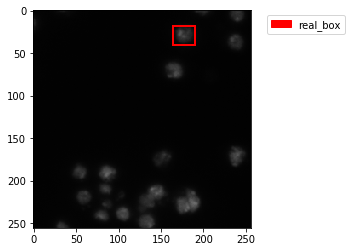

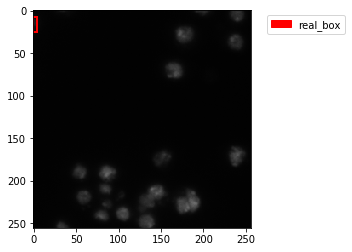

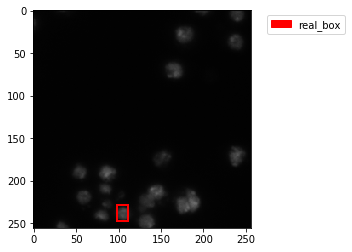

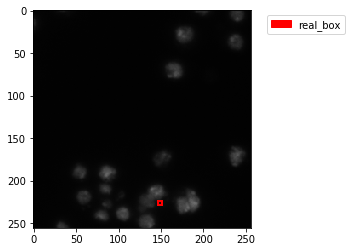

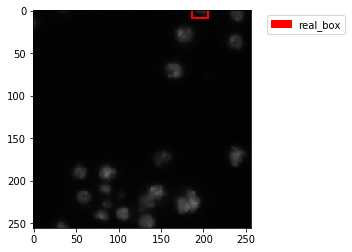

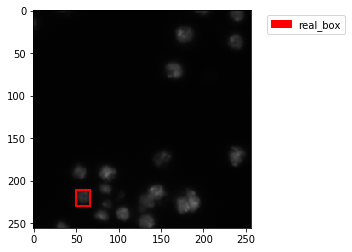

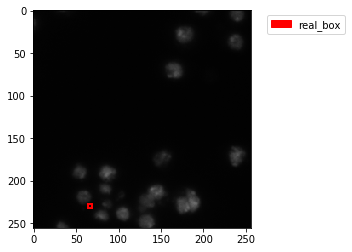

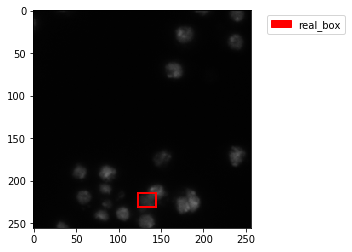

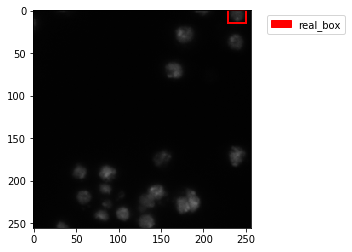

In [27]:
image_bounding_boxes = []
for mask_img in test_mask_files:
    mask_img = mpimg.imread(mask_img)
    img_array = np.array(mask_img)
    box_center_x,box_center_y,box_height,box_width,box_start_x,box_end_x,box_start_y,box_end_y = calc_mask_bounding_box(img_array)
    image_bounding_boxes.append([box_center_x,box_center_y,box_height,box_width])
    print('AREA: ', (box_width*box_height))
    show_image_and_bounding_box(image, box_center_x,box_center_y,box_height,box_width, 'red', 'real_box')

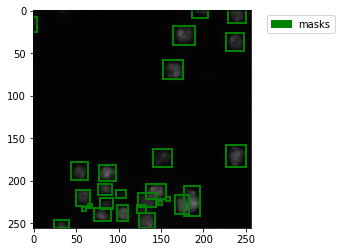

In [29]:
show_image_and_multiple_bounding_boxes(image,image_bounding_boxes,"green","masks")